## 1

In [18]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

file_path = "proshares_analysis_data.xlsx"

# Read the Excel file
hf_data = pd.read_excel(file_path, 
                     sheet_name="hedge_fund_series",
                     index_col = 0, 
                     parse_dates = True)
hf_data.index.name = "Date"
hf_data.head()

merrill_data = pd.read_excel(file_path, sheet_name = "merrill_factors",
                             index_col = 0,
                             parse_dates = True)
merrill_data.index.name = "Date"
merrill_data.head()

other_data = pd.read_excel(file_path, sheet_name = "other_data", 
                           index_col = 0,
                           parse_dates = True)
other_data.index.name = "Date"



In [19]:
#Summary Stats

def summary_stats(data):
    annualized_mean = data.mean() * 12
    annualized_vol = data.std() * np.sqrt(12)
    annualized_sharpe = (data.mean()/data.std()) * np.sqrt(12)
    summary_df = pd.DataFrame({
        "Annualized Mean": annualized_mean.round(5),
        "Annualized Volatility": annualized_vol.round(5),
        "Annualized Sharpe Ratio": annualized_sharpe.round(5)
    }).T
    return summary_df

hf_stats = summary_stats(hf_data)
hf_stats


,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
Annualized Mean,0.05128,0.03853,0.03653,0.02688,0.02881
Annualized Volatility,0.05880,0.05524,0.05510,0.05739,0.04982
Annualized Sharpe Ratio,0.87215,0.69759,0.66288,0.46840,0.57827


## 2

In [20]:
#Additional Statistics

def tail_risk_stats(data):
    """
    Helper Function to calculate these stats for a particular secuirty
        in the larger dataframe
    """
    skewness = data.skew().round(5)
    kurtosis = data.kurt().round(5)
    quantile_05 = data.quantile(0.05).round(5)
    cvar_05 = data[data <= quantile_05].mean().round(5)

    #Summarize tail risk stats:
    tail_risk_stats_df = pd.DataFrame({
        "Skewness": skewness,
        "Kurtosis": kurtosis,
        "VaR (0.05)": quantile_05,
        "CVaR (0.05)": cvar_05
    })
    return tail_risk_stats_df

tail_risk_df = tail_risk_stats(hf_data)
tail_risk_df

,Skewness,Kurtosis,VaR (0.05),CVaR (0.05)
HFRIFWI Index,-0.94827,5.65735,-0.02401,-0.03599
MLEIFCTR Index,-0.28998,1.63092,-0.02700,-0.03499
MLEIFCTX Index,-0.27348,1.58979,-0.02697,-0.03494
HDG US Equity,-0.27490,1.77648,-0.02992,-0.03683
QAI US Equity,-0.43351,1.44918,-0.01717,-0.03099


In [21]:
#MDD Data:
def max_drawdown_with_dates(series: pd.Series):
    s = series.dropna()
    if s.empty:
        return pd.Series([np.nan, pd.NaT, pd.NaT, pd.NaT],
                         index=["Max Drawdown", "Peak Date", "Trough Date", "Recovery Date"])

    wealth = (1 + s).cumprod()
    run_max = wealth.cummax()
    dd = wealth / run_max - 1.0

    trough_idx = dd.idxmin()
    mdd = dd.loc[trough_idx]

    # Calculate Max
    pre_trough = dd.loc[:trough_idx]
    peak_candidates = pre_trough[pre_trough == 0.0]
    peak_date = peak_candidates.index.max() if not peak_candidates.empty else s.index.min()

    # Calculate Recovery
    prev_peak_level = run_max.loc[trough_idx]
    post_trough = wealth.loc[trough_idx:]
    recovered = post_trough[post_trough >= prev_peak_level]
    recovery_date = recovered.index.min() if not recovered.empty else pd.NaT

    return pd.Series([mdd, peak_date, trough_idx, recovery_date],
                     index=["Max Drawdown", "Peak Date", "Trough Date", "Recovery Date"])

mdd_table = hf_data.apply(max_drawdown_with_dates, axis=0).T
mdd_table.index.name = "Series"
mdd_table = mdd_table.reset_index()
mdd_table

,Series,Max Drawdown,Peak Date,Trough Date,Recovery Date
0,HFRIFWI Index,-0.115473,2019-12-31 00:00:00,2020-03-31 00:00:00,2020-08-31 00:00:00
1,MLEIFCTR Index,-0.124302,2021-06-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00
2,MLEIFCTX Index,-0.124388,2021-06-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00
3,HDG US Equity,-0.14072,2021-06-30 00:00:00,2022-09-30 00:00:00,2024-07-31 00:00:00
4,QAI US Equity,-0.137716,2021-06-30 00:00:00,2022-09-30 00:00:00,2024-02-29 00:00:00


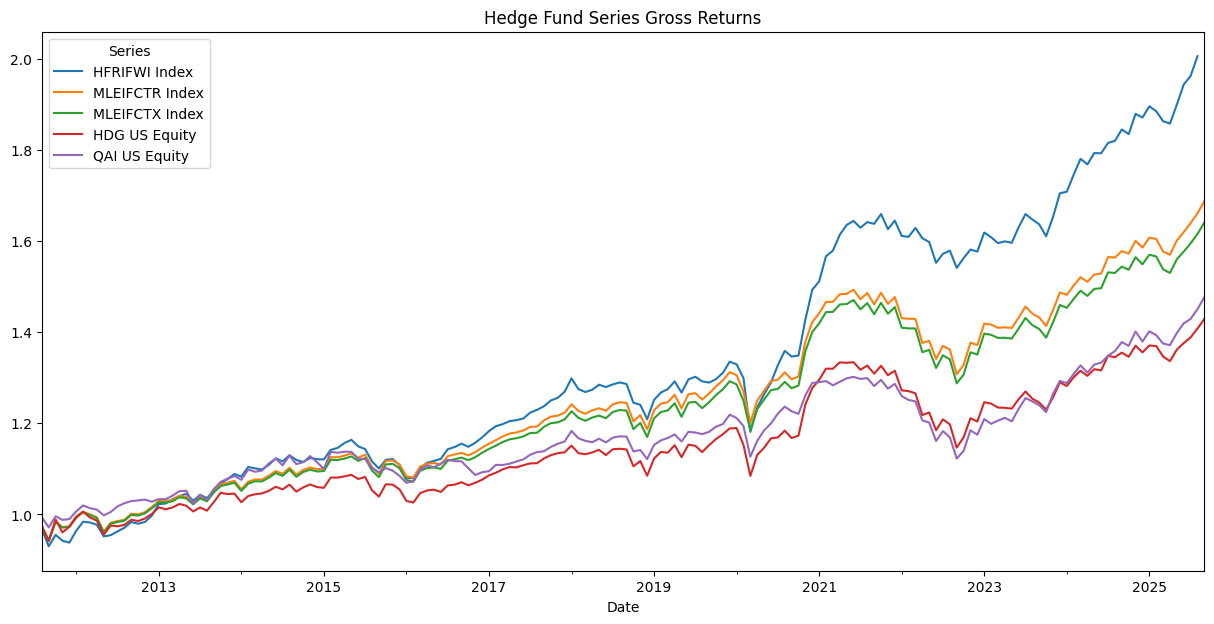

In [22]:
# Show plot
(hf_data + 1).cumprod().plot(figsize=(15, 7), title='Hedge Fund Series Gross Returns')
plt.show()

## 3

In [23]:
#Part 3: regress against SPY, show OLS statistics

merrill_SPY = merrill_data[["SPY US Equity"]]
x = sm.add_constant(merrill_SPY)

regression_stats_df = pd.DataFrame( index = ["SPY Beta", "Treynor Ratio", "Information Ratio"], 
                                columns = hf_data.columns)

for hf in hf_data.columns:
    y = hf_data[hf]
    hf_model = sm.OLS(y,x, missing = 'drop').fit()
    beta = hf_model.params.iloc[1]
    annualized_treynor = 12 *  y.mean()/beta 
    annualized_information = (hf_model.params.iloc[0] / hf_model.resid.std()) * np.sqrt(12)

    regression_stats_df[hf] = pd.Series([beta, annualized_treynor, annualized_information], 
                                    index = ["SPY Beta", "Treynor Ratio", "Information Ratio"])

    regression_stats_df.round(5)


In [24]:
#Annualized regression statistics:
regression_stats_df

Series,HFRIFWI Index,MLEIFCTR Index,MLEIFCTX Index,HDG US Equity,QAI US Equity
SPY Beta,0.346312,0.342487,0.341483,0.350602,0.301413
Treynor Ratio,0.148072,0.112514,0.106963,0.076669,0.095587
Information Ratio,0.055336,-0.436440,-0.510548,-0.862386,-0.597796


## 4

###
Discussion of Statistics:

(a)	SPY exhibits higher risk and higher return; the hedge fund series have β ≈ 0.35, with lower volatility but overall lower returns and negative IR.

(b)	The two funds have similar β values; QAI shows a higher Treynor ratio and a better IR, indicating slightly better performance.

(c)	Their β structures are similar, meaning they can replicate the systematic risk of hedge funds, but they fail to replicate the alpha (HFRI has the highest Treynor ratio).

## 5

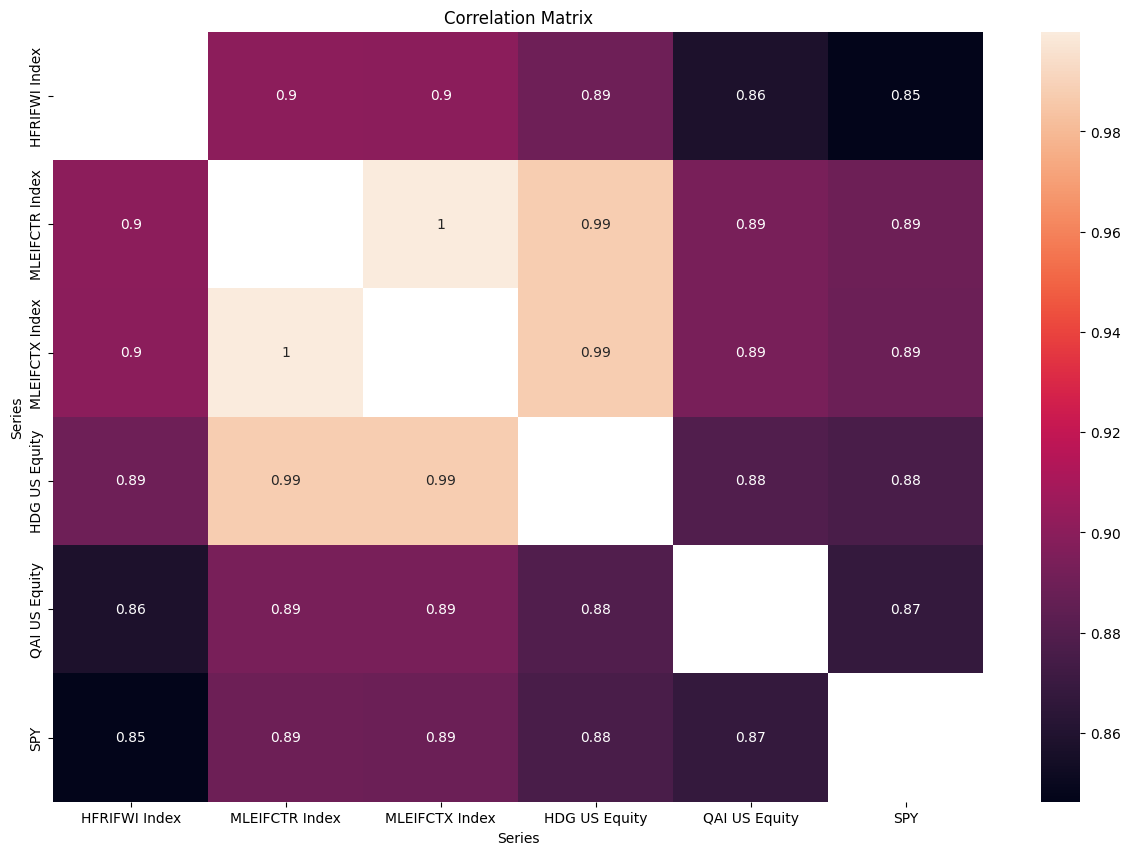

In [25]:
#Correlation Matrix
correlations = hf_data.assign(SPY = merrill_SPY).corr()
np.fill_diagonal(correlations.values, np.nan)
plt.figure(figsize = (15, 10))
sns.heatmap(correlations, annot = True)
plt.title("Correlation Matrix")
plt.show()

In [26]:
#Highest Correlations
correlation_pairs = correlations.stack()
correlation_pairs = correlation_pairs[correlation_pairs != 1 ]
highest_pair, highest_corr = correlation_pairs.idxmax(), correlation_pairs.max()
lowest_pair, lowest_corr = correlation_pairs.idxmin(), correlation_pairs.min()

print("Highest correlation:", highest_pair, highest_corr.round(5))
print("Lowest correlation:", lowest_pair, lowest_corr.round(5))

AttributeError: 'float' object has no attribute 'round'

## 6

In [ ]:
## Unrestricted Regression
y = hf_data[["HFRIFWI Index"]]
x = sm.add_constant(merrill_data)
unrestricted_model = sm.OLS(y,x, missing = 'drop').fit()
print(unrestricted_model.summary())


                            OLS Regression Results                            
Dep. Variable:          HFRIFWI Index   R-squared:                       0.843
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     144.6
Date:                Fri, 10 Oct 2025   Prob (F-statistic):           2.10e-62
Time:                        17:11:04   Log-Likelihood:                 605.85
No. Observations:                 169   AIC:                            -1198.
Df Residuals:                     162   BIC:                            -1176.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0011      0.001      1.631

In [ ]:
#Summary Statistics:    
print("(a) Intercept:", unrestricted_model.params.iloc[0])
print("\nBetas:", (unrestricted_model.params.iloc[1:]))
print("\n (c) R^2", unrestricted_model.rsquared)
print("\n (d) Volatility of Tracking Error", unrestricted_model.resid.std() * np.sqrt(12) )


(a) Intercept: 0.001148772719442212

Betas: SPY US Equity    0.043503
USGG3M Index     0.324931
EEM US Equity    0.085564
EFA US Equity    0.073994
EUO US Equity    0.029614
IWM US Equity    0.145824
dtype: float64

 (c) R^2 0.8426938827413941

 (d) Volatility of Tracking Error 0.023319705890296756


## 
(b) The betas for each of the US Equities sum to approximately the beta for the USGG3M Index. Thus, with the indivudal Equities, we can replicate the contribution of USGG3M in the linear regression against the HFRIFWI Index. Also, since all of the Betas are relatively small and only sum to ~0.7, we do not need to take huge long or short positions in any of them. 

## 7

In [ ]:
## OOS Examination

def oos_replication(target, regressors, window = 60):
    oos_predictions = []
    actual_vals = []
    target_name = target.name if target.name else "Actual"

    for i in range(window, len(target)):
        y_train = target.iloc[i - window: i]
        x_train = regressors.iloc[i-window : i]

        x_current = regressors.iloc[i: i+1]

        model = LinearRegression()
        model.fit(x_train, y_train)
        pred = model.predict(x_current)[0]

        oos_predictions.append(pred)
        actual_vals.append(target.iloc[i])

    results = pd.DataFrame({
        target_name: actual_vals,
        "Predictions": oos_predictions
    }, index = target.index[window:])

    oos_loss = ((results[target_name] - results["Predictions"]) **2).sum()
    oos_mean = results[target_name].mean()
    oos_loss_null = ((results[target_name] - oos_mean) ** 2).sum()
    oos_r2 = 1 - oos_loss / oos_loss_null

    print(f"OOS R^2 of Replication: ", oos_r2.round(5))
    print("\nCorrelation Matrix:")
    print(results.corr().round(5))

    return results

oos_replication(hf_data["HFRIFWI Index"], merrill_data)

OOS R^2 of Replication:  0.80547

Correlation Matrix:
               HFRIFWI Index  Predictions
HFRIFWI Index        1.00000      0.90132
Predictions          0.90132      1.00000


,HFRIFWI Index,Predictions
Date,,
2016-08-31,0.004274,0.004966
2016-09-30,0.006468,0.005001
2016-10-31,-0.005947,-0.004449
2016-11-30,0.007660,0.011650
2016-12-31,0.010063,0.007650
...,...,...
2025-05-31,0.022300,0.018062
2025-06-30,0.023300,0.021267
2025-07-31,0.009700,0.006974


###
From the results above, it looks like the replication portfolio did a good job of tracking the index returns. The correlation between HFRIFWI Index and the Replication is 0.90132, which is signficiantly high.
Also, the OOS R^2 is relatively high, which shows this regression works well OOS.

OOS R^2 of Replication:  0.80547

Correlation Matrix:
               HFRIFWI Index  Predictions
HFRIFWI Index        1.00000      0.90132
Predictions          0.90132      1.00000


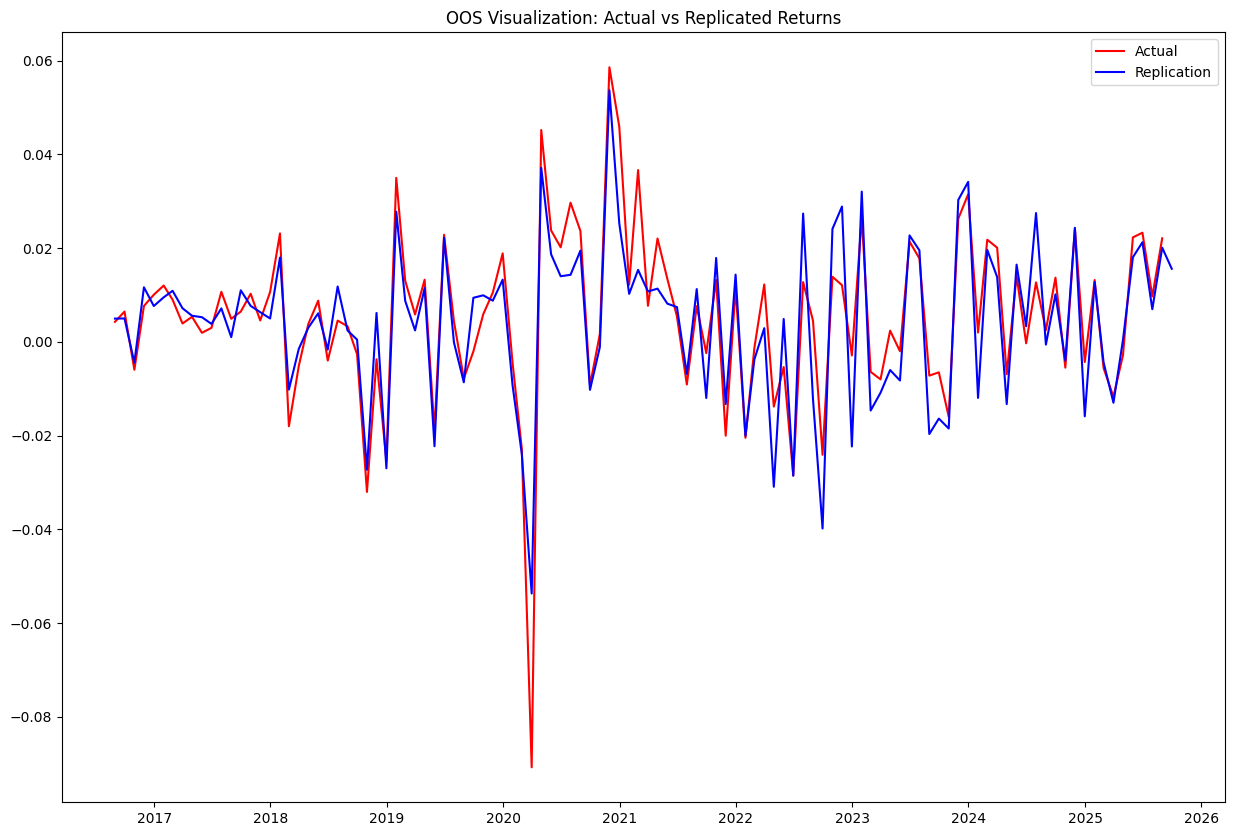

In [ ]:
#Plot Results:
results = oos_replication(hf_data["HFRIFWI Index"], merrill_data)
target_name = "HFRIFWI Index"

plt.figure(figsize = (15, 10))
plt.plot(results.index, results[target_name], label = "Actual", color = "red")
plt.plot(results.index, results["Predictions"], label = "Replication", color = "blue")
plt.title("OOS Visualization: Actual vs Replicated Returns")
plt.legend()
plt.show()

OOS R^2 of Replication:  0.80547

Correlation Matrix:
               HFRIFWI Index  Predictions
HFRIFWI Index        1.00000      0.90132
Predictions          0.90132      1.00000


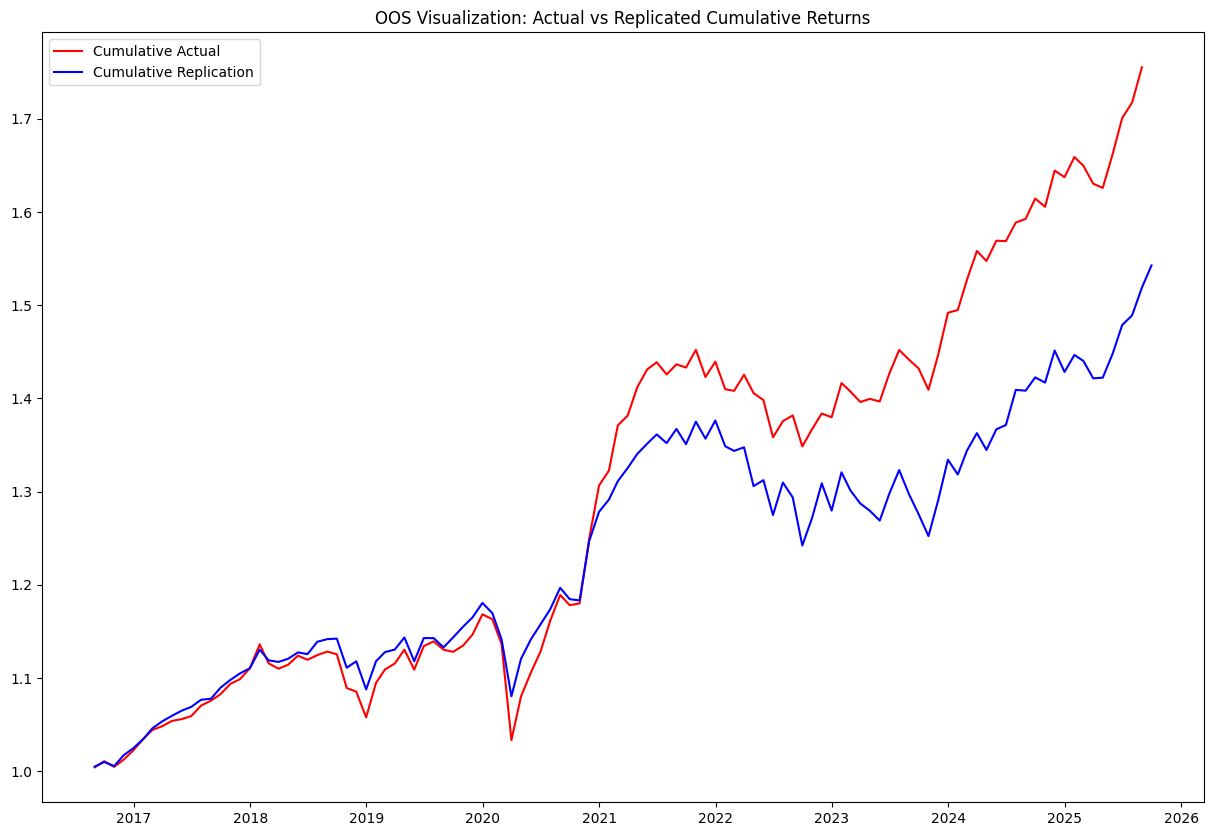

In [ ]:
#Cumulative Returns Plot
results = oos_replication(hf_data["HFRIFWI Index"], merrill_data)
target_name = "HFRIFWI Index"

plt.figure(figsize = (15, 10))
cum_actual = (1 + results[target_name]).cumprod()
cum_replication = (1 + results["Predictions"]).cumprod()
plt.plot(results.index, cum_actual, label = "Cumulative Actual", color = "red")
plt.plot(results.index, cum_replication, label = "Cumulative Replication", color = "blue")
plt.title("OOS Visualization: Actual vs Replicated Cumulative Returns")
plt.legend()
plt.show()

###
After visualizing the cumulative returns, it's apparent that our predicitons start following closely to the actual values but ultiamtely diverge after 2021. This indicates that the replicated values are likely not an ideal prediction for the HFRIFWI Index following 2021.